## Necessary Imports

In [1]:
%load_ext autoreload
%autoreload 2

import math
import os
import json

import tensorflow as tf
import tensorflow.keras as keras

import librosa

import numpy as np
import seaborn as sns
import pandas as pd

from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
%matplotlib inline

# custom helper functions
from utils import *

RANDOM_SEED = 0

2022-05-02 22:35:56.040794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 22:35:56.040845: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Load Data

In [2]:
FMA_JSON_PATH = "/storage/graham/music/fma_small_data.json"
MODEL_PATH = "/storage/graham/music/models/"

GTZAN_SAMPLE_RATE = 22050  # gtzan sample rate
FMA_SAMPLE_RATE = GTZAN_SAMPLE_RATE * 2  # fma sample rate
DURATION = 30  # measure in seconds

In [3]:
%%time
genres, X, y = load_mfcc_data(FMA_JSON_PATH)

CPU times: user 2min 29s, sys: 12.4 s, total: 2min 42s
Wall time: 2min 42s


In [4]:
# create train/test split
X_db = librosa.power_to_db(X)
X_train, X_val, X_test, y_train, y_val, y_test = test_train_val_split(X_db, y)

In [5]:
def map_to_integer_interval(old_lo, old_hi, new_lo, new_hi, x):
    return np.round(new_lo + (new_hi - new_lo)/(old_hi - old_lo)*(x - old_lo))

## Resize Data to be compatible with ResNet18

In [6]:
# prep data for CNN / reshape

size = 224

# convert to grayscale
X_train = map_to_integer_interval(np.min(X_db), np.max(X_db), 0., 255., X_train)
X_val = map_to_integer_interval(np.min(X_db), np.max(X_db), 0., 255., X_val)
X_test = map_to_integer_interval(np.min(X_db), np.max(X_db), 0., 255., X_test)

X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

X_train_cnn = tf.image.resize_with_pad(X_train_cnn, target_height=size, target_width=size).numpy()
X_val_cnn = tf.image.resize_with_pad(X_val_cnn, target_height=size, target_width=size).numpy()
X_test_cnn = tf.image.resize_with_pad(X_test_cnn, target_height=size, target_width=size).numpy()

X_train_cnn = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_train_cnn))
X_val_cnn = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_val_cnn))
X_test_cnn = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_test_cnn))

2022-05-02 22:38:53.121239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-02 22:38:53.121296: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-02 22:38:53.121317: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (earhart): /proc/driver/nvidia/version does not exist
2022-05-02 22:38:53.121720: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load in Base Model

In [7]:
base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [8]:
inputs = keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(len(genres))(x)
resnet = keras.Model(inputs, outputs)
resnet._name = "ResNet"

resnet.summary()

Model: "ResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
Total params: 23,604,104
Trainable params: 23,550,984
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
optimiser = keras.optimizers.Adam(learning_rate=0.001)
resnet.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

MODEL_SAVE_PATH = MODEL_PATH + "/resnet/"
saveBest, es, lr = setup_callbacks(resnet, MODEL_SAVE_PATH)

history = resnet.fit(X_train_cnn, y_train, 
          epochs=10, 
          batch_size=32,
          callbacks=[saveBest, es, lr], 
          validation_data=(X_val_cnn, y_val))

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = resnet.evaluate(X_test_cnn, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/10
 167/1152 [===>..........................] - ETA: 47:55 - loss: 7.6743 - accuracy: 0.1319

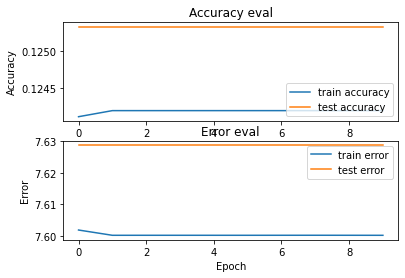

705/705 - 376s - loss: 7.7079 - accuracy: 0.1257 - 376s/epoch - 533ms/step

Test accuracy: 0.12567603588104248


In [12]:
# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = resnet.evaluate(X_test_cnn, y_test, verbose=2)
print('\nTest accuracy:', test_acc)